<a href="https://colab.research.google.com/github/PihuNiranjan/Alexa-using-python/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Mount Google Drive if needed ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [3]:

# === Load dataset ===
df = pd.read_csv("drive/MyDrive/dataset/dataset_gas_used.csv")


In [4]:

# === Drop irrelevant columns ===
df.drop(columns=["Transaction Hash", "Opcodes Generated", "Top 3 opcodes"], inplace=True, errors='ignore')


In [5]:

# === Target variable ===
target = "Gas Used"
df = df.dropna(subset=[target])


In [6]:
# # === Feature grouping ===
# numerical_features = [
#     "Gas Limit", "Gas Price(Gwei)", "Transaction Fee (Ethers)", "Total Functions Involved",
#     "Sstore", "Sstore Gas", "Sload", "SLoadGas", "LOG", "LOG Gas", "SHA3", "SHA3 Gas",
#     "Create", "Create Gas", "Call", "Call Gas", "Jumpi", "Jumpi Gas", "Balance", "Balance Gas",
#     "SelfDestruct", "SelfDestruct Gas", "CodeCopy", "CodeCopy Gas", "EXTCODESIZE", "EXTCODESIZE Gas",
#     "Require", "Conditions in If", "No of events"
# ]

# boolean_features = [
#     "Require Used", "Loop_Used", "If_Condition", "Event_Triggered",
#     "Pushing_Values_in_Array", "Nested_Require", "Payable"
# ]

# categorical_features = [
#     "Smart Contract Address", "Smart Contract Name", "Function  Executed",
#     "Function Type", "Calling_Function", "Array Type", "Compiler Version"
# ]

# used_features = numerical_features + boolean_features + categorical_features

# === Feature grouping after removing leakage and gas-derived features ===
numerical_features = [
    "Gas Limit", "Gas Price(Gwei)", "Total Functions Involved",
    "Sstore", "Sload", "LOG", "SHA3",
    "Create", "Call", "Jumpi", "Balance",
    "SelfDestruct", "CodeCopy", "EXTCODESIZE",
    "Require", "Conditions in If", "No of events"
]

boolean_features = [
    "Require Used", "Loop_Used", "If_Condition", "Event_Triggered",
    "Pushing_Values_in_Array", "Nested_Require", "Payable"
]

categorical_features = [
    "Smart Contract Address", "Smart Contract Name", "Function  Executed",
    "Function Type", "Calling_Function", "Array Type", "Compiler Version"
]

used_features = numerical_features + boolean_features + categorical_features



In [7]:

# === Clean data: fill missing values, type conversion ===
df[numerical_features] = df[numerical_features].fillna(0)
df[boolean_features] = df[boolean_features].fillna(False).astype(int)
df[categorical_features] = df[categorical_features].fillna("Unknown")
df.columns = df.columns.str.strip()


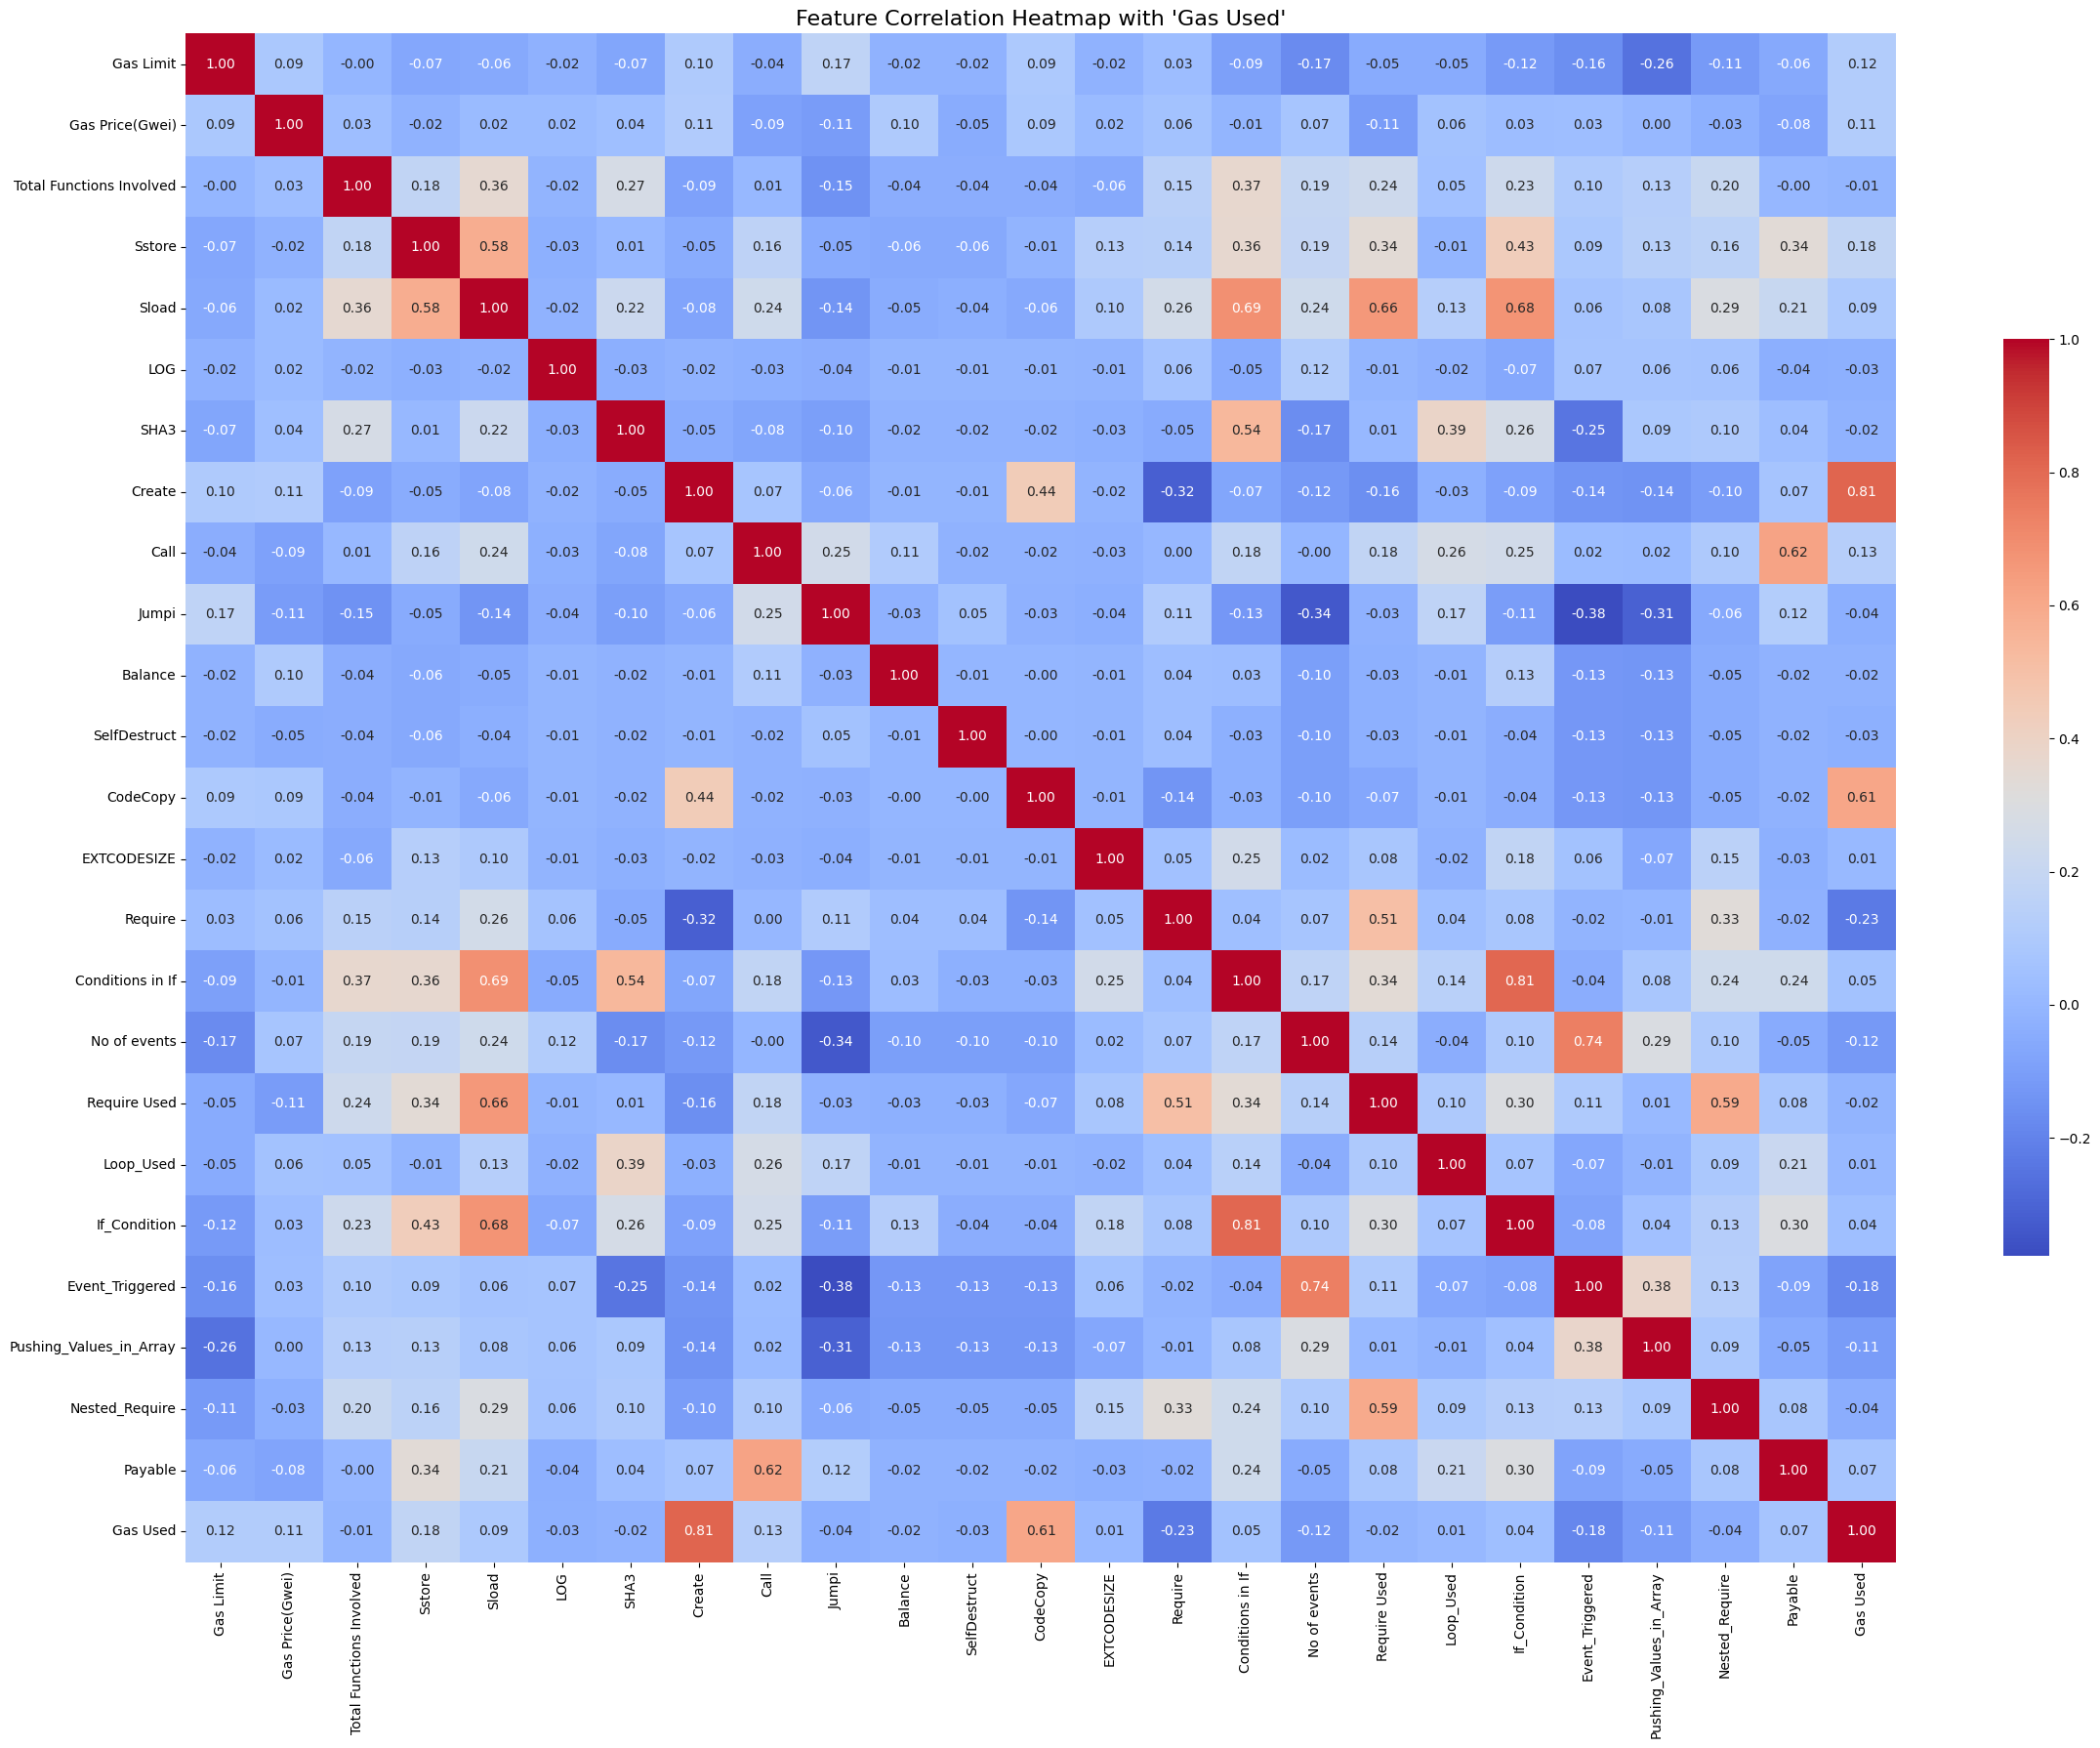

In [8]:

# === Correlation Heatmap ===
corr_matrix = df[numerical_features + boolean_features + [target]].corr()
plt.figure(figsize=(24, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'shrink': .6})
plt.title("Feature Correlation Heatmap with 'Gas Used'", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# === Split dataset ===
X = df[used_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
# === Preprocessing pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

In [11]:
# === Define regression models ===
from sklearn.linear_model import Ridge, Lasso

models = {
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    "SVR": SVR(kernel='rbf'),
    # "Ridge Regression": Ridge(alpha=1.0), # Added Ridge Regression
    # "Lasso Regression": Lasso(alpha=0.1) # Added Lasso Regression
}

In [12]:
# === Train and evaluate models ===
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R² Score": r2_score(y_test, y_pred)
    })

In [13]:
# === Display results ===
results_df = pd.DataFrame(results)
print(results_df)

               Model           MAE           RMSE  R² Score
0            XGBoost    995.380798    1178.309329  0.999947
1  Linear Regression     78.914760     298.174785  0.999997
2      Random Forest   7128.297248   10341.503509  0.995908
3  Gradient Boosting    974.776844    1114.414606  0.999952
4                SVR  43188.693218  165660.607487 -0.050070


In [14]:

# === Visual Comparison ===
sns.set(style="whitegrid")

/tmp/ipython-input-1846297785.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.sort_values("MAE"), x="Model", y="MAE", palette="Blues_d")


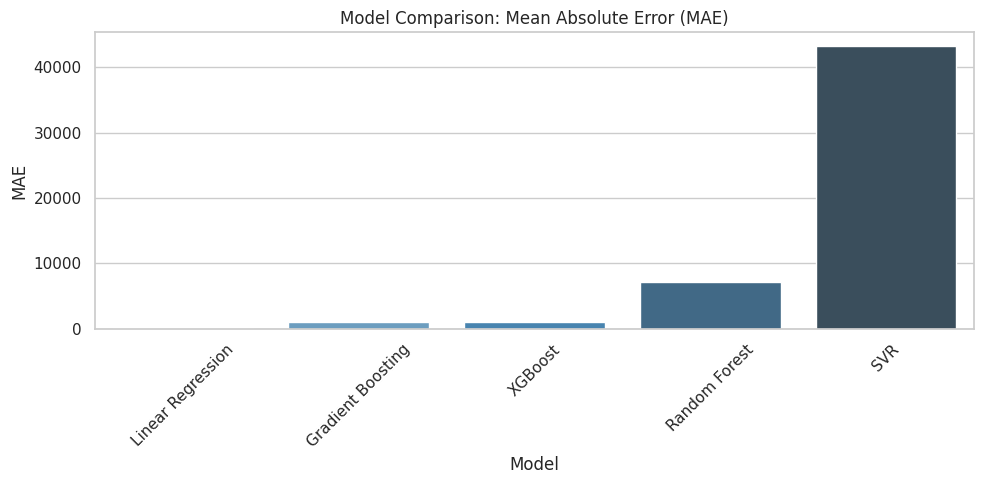

In [15]:
# MAE barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.sort_values("MAE"), x="Model", y="MAE", palette="Blues_d")
plt.title("Model Comparison: Mean Absolute Error (MAE)")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2695714697.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.sort_values("RMSE"), x="Model", y="RMSE", palette="Purples")


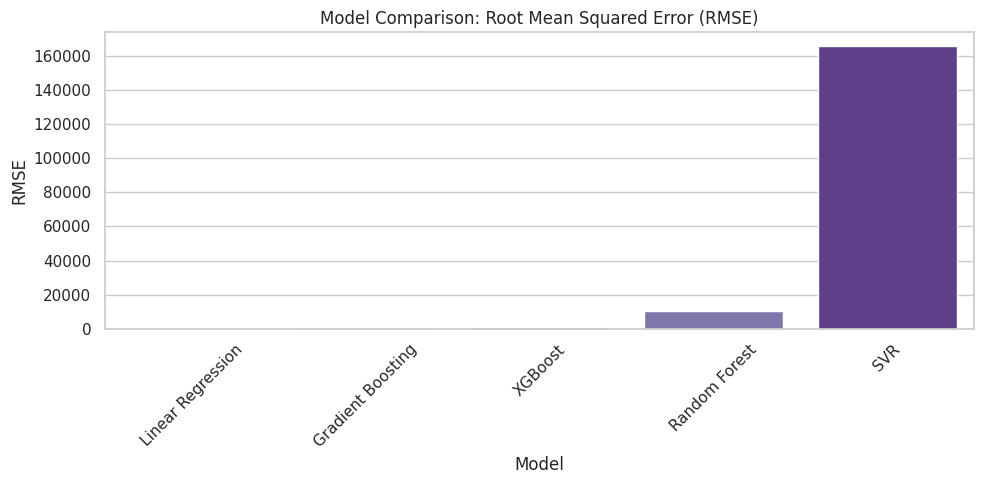

In [16]:
# RMSE barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.sort_values("RMSE"), x="Model", y="RMSE", palette="Purples")
plt.title("Model Comparison: Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-4102391842.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.sort_values("R² Score", ascending=False), x="Model", y="R² Score", palette="Set2")


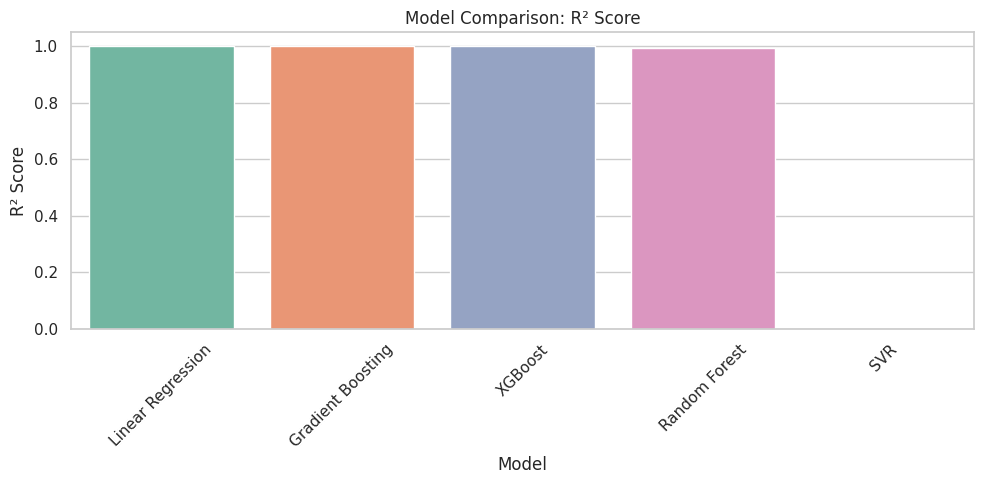

In [17]:
# R² Score barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.sort_values("R² Score", ascending=False), x="Model", y="R² Score", palette="Set2")
plt.title("Model Comparison: R² Score")
plt.ylabel("R² Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

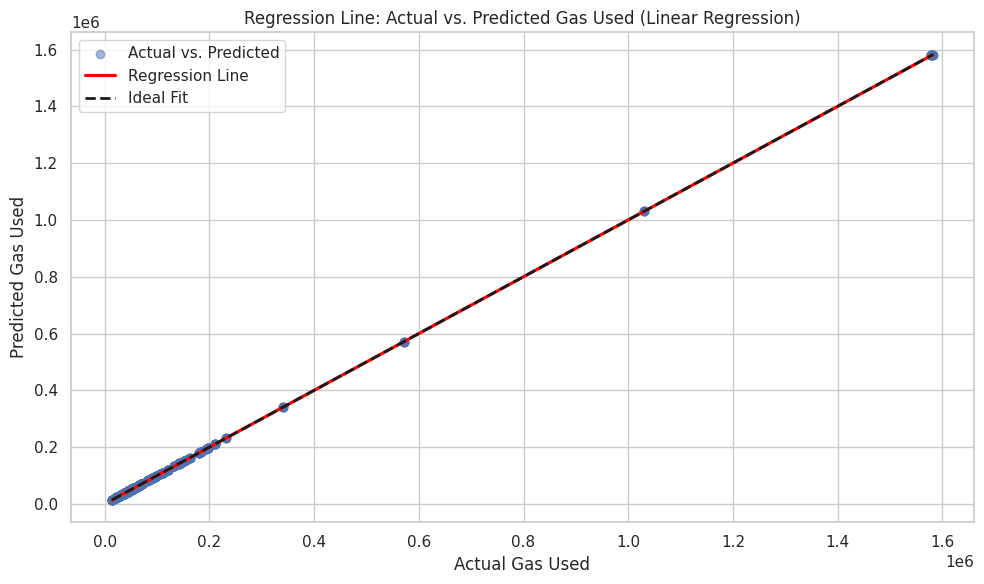

In [18]:
# === Regression Line Plot for Linear Regression ===
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Actual vs. Predicted')
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color='red', label='Regression Line')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel("Actual Gas Used")
plt.ylabel("Predicted Gas Used")
plt.title("Regression Line: Actual vs. Predicted Gas Used (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# === Display updated results ===
results_df = pd.DataFrame(results)
print(results_df)

               Model           MAE           RMSE  R² Score
0            XGBoost    995.380798    1178.309329  0.999947
1  Linear Regression     78.914760     298.174785  0.999997
2      Random Forest   7128.297248   10341.503509  0.995908
3  Gradient Boosting    974.776844    1114.414606  0.999952
4                SVR  43188.693218  165660.607487 -0.050070


In [20]:
# === Train and evaluate models ===
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R² Score": r2_score(y_test, y_pred)
    })

## Model Performance and Analysis

Based on the evaluation metrics (MAE, RMSE, R² Score), the models, particularly Linear Regression, XGBoost, and Gradient Boosting, show very high performance with R² scores close to 1. This indicates that these models are able to explain a significant portion of the variance in the "Gas Used" target variable and make accurate predictions.

### Why the models work well:

*   **Relevant Features:** The selected features likely have a strong relationship with the "Gas Used" variable, allowing the models to learn the underlying patterns effectively.
*   **Data Quality:** The data appears to be relatively clean and well-structured, which is crucial for training accurate models.
*   **Appropriate Models:** Linear Regression, XGBoost, and Gradient Boosting are powerful algorithms that can capture complex relationships in data. Linear Regression, despite its simplicity, performs exceptionally well here, suggesting a strong linear component in the data or that the preprocessing has made the data more linearly separable.

### Strengths:

*   **High Accuracy:** The models demonstrate high accuracy in predicting "Gas Used," which is evident from the low MAE and RMSE values and high R² scores.
*   **Interpretability (Linear Regression):** Linear Regression offers good interpretability, allowing us to understand the impact of individual features on the predicted gas usage.
*   **Robustness (XGBoost, Gradient Boosting, Random Forest):** Ensemble methods like XGBoost, Gradient Boosting, and Random Forest are generally robust to outliers and can handle non-linear relationships.

### Limitations:

*   **Data Leakage Potential:** While efforts were made to remove gas-derived features, there might still be potential for subtle data leakage or features that are highly correlated with the target due to the nature of gas usage calculation. Further domain expertise and feature analysis might be needed to completely rule this out.
*   **Generalizability:** The models' performance might vary when applied to new or significantly different types of smart contracts or blockchain networks than those in the training data.
*   **Categorical Feature Handling:** The OneHotEncoder for categorical features can lead to a high-dimensional feature space, which might impact performance or training time for some models.
*   **SVR Performance:** The SVR model performed poorly, suggesting that the chosen kernel or hyperparameters are not suitable for this dataset, or that SVR is not the best model for this specific regression task.

### Further Steps:

*   Investigate potential data leakage more thoroughly.
*   Explore more advanced feature engineering techniques.
*   Fine-tune hyperparameters for all models, especially SVR.
*   Consider cross-validation for more robust evaluation.
*   Test the models on external datasets to assess generalizability.